In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [3]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# Camera calibration 
https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html

In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

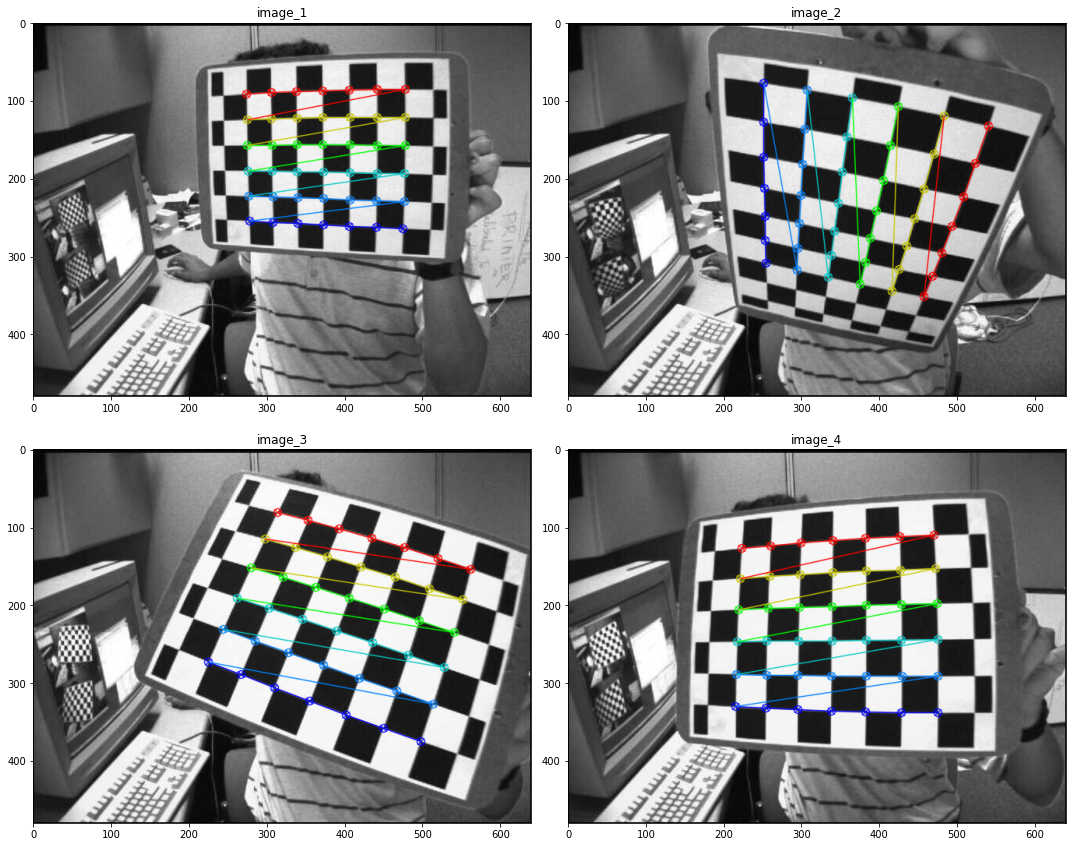

In [6]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
container = []

images = glob.glob('/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/chess/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        # cv2_imshow(img)
        container.append(img)

fig = plt.figure(figsize=(15, 12))
plt.subplot(221), plt.imshow(container[0]), plt.title('image_1')
plt.subplot(222), plt.imshow(container[1]), plt.title('image_2')
plt.subplot(223), plt.imshow(container[2]), plt.title('image_3')
plt.subplot(224), plt.imshow(container[3]), plt.title('image_4')
plt.tight_layout()
plt.show()

In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

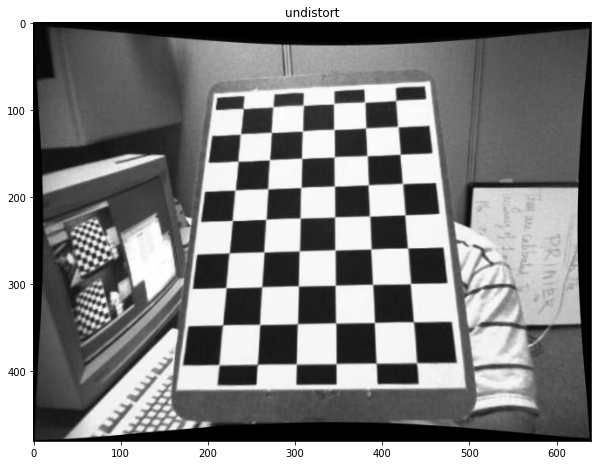

True

In [9]:
img = cv2.imread('/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/chess/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

fig = plt.figure(figsize=(10, 10))
plt.imshow(dst,'gray')
plt.title('undistort')
plt.show()

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('./calibresult.png', dst)

# Pose Estimation
https://docs.opencv.org/3.3.0/d7/d53/tutorial_py_pose.html

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*7,3), np.float32)

objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

In [11]:
print(f"mtx shape: {mtx.shape}, \n\ndistortion shape: {dist.shape} \n")
print("corners2 shape: ", corners2.shape)

mtx shape: (3, 3), 

distortion shape: (1, 5) 

corners2 shape:  (42, 1, 2)


In [12]:
def draw_axis(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img
    
def draw_cube(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

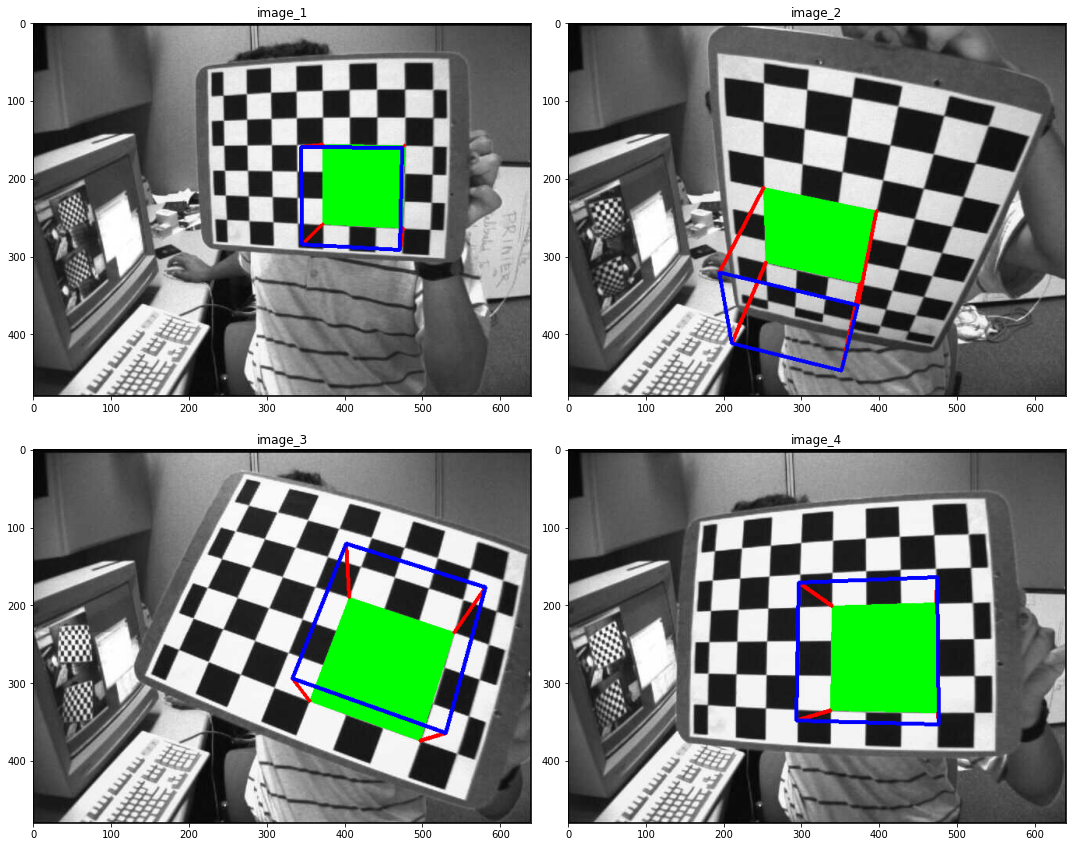

In [14]:
container = []
for fname in glob.glob('/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/chess/*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw_cube(img, corners2, imgpts)
        # cv2_imshow(img)
        container.append(img)

fig = plt.figure(figsize=(15, 12))
plt.subplot(221), plt.imshow(container[0]), plt.title('image_1')
plt.subplot(222), plt.imshow(container[1]), plt.title('image_2')
plt.subplot(223), plt.imshow(container[2]), plt.title('image_3')
plt.subplot(224), plt.imshow(container[3]), plt.title('image_4')
plt.tight_layout()
plt.show()